### Overview

This lab will go over how language-encoding models such as BERT can be used to tackle for a variety of language tasks.

Because BERT has been pretrained on a large corpus of text, BERT can be easily fine-tuned to achieve strong performance on downstream tasks.

(Note: For this lab, we will use RoBERTa instead of BERT. RoBERTa is very similar to BERT, except it is trained on more data on only using an MLM objective, with no NSP. RoBERTa generally has better performance than BERT, but both are very similar models.)

As a recap, let's go over what the three major classes of representation models we've seen:

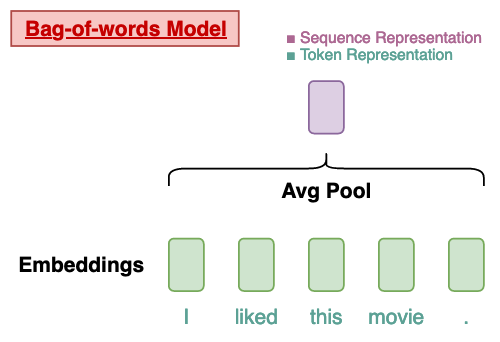

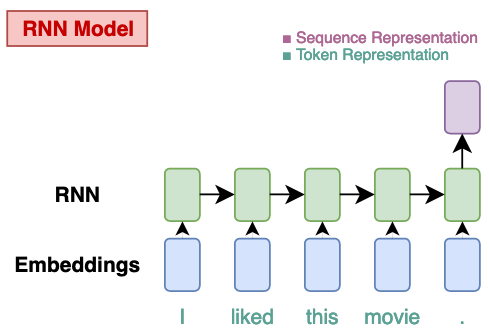

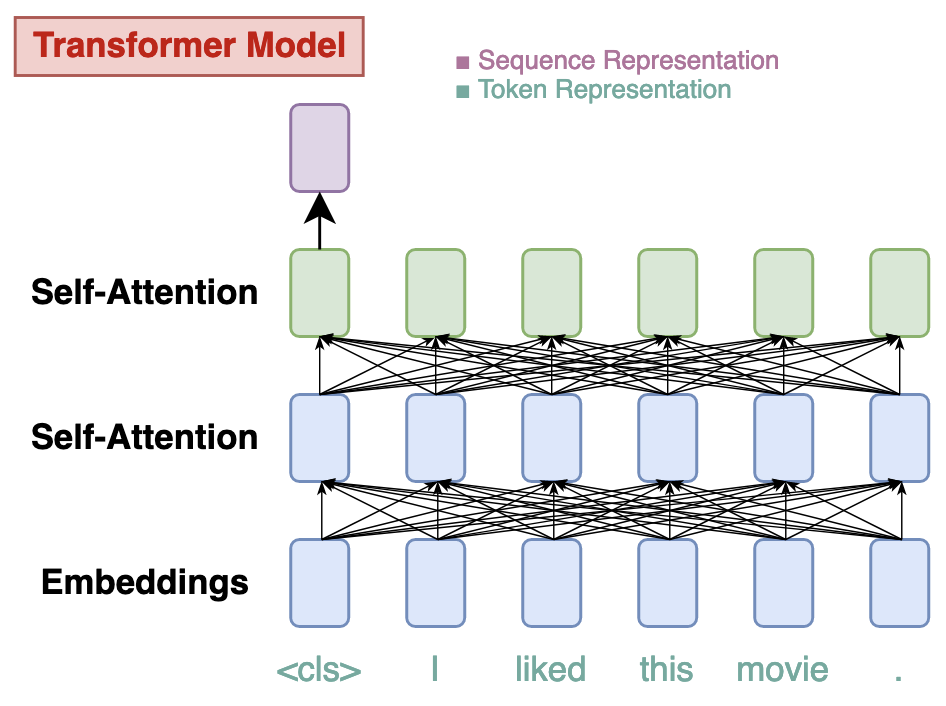

In this lab, we will make heavy use of 3 Hugging Face libraries:

- `datasets` ([link](https://github.com/huggingface/datasets)) for downloading and preprocessing datasets as well as metrics
- `tokenizers` ([link](https://github.com/huggingface/datasets)), used for fast tokenization, imported by `transformers`
- `transformers` ([link](https://github.com/huggingface/transformers)) for access to many cutting-edge Transformer-based model implementations, along with pretrained weights

In [ ]:
! pip install datasets transformers tqdm

### BERT for Classification

We will start by considering a simple text-classification task. For this lab, we will use the RTE (Recognizing Textual Entailment) task. It is a two-input, two class classification task. 

Here are two examples:

```
Example 1:
  Premise: Two dogs are playing in the park.
  Hypothesis: There are animals in the park.
  Label: Entailment
```

```
Example 2:
  Premise: Two dogs are playing in the park.
  Hypothesis: There are cats in the park.
  Label: Not Entailment
```

Given the premise, we want to know if the premise **entails** the hypothesis.

In [ ]:
import numpy as np
import datasets
import torch
import torch.nn as nn
from transformers import AdamW
import transformers
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
import tqdm.notebook as tqdm

DEVICE = torch.device("cuda:0")
def to_device(batch):
  return {
      k: v.to(DEVICE)
      for k, v in batch.items()
  }

#### Data

First, let's go over how to use `datasets` to load the RTE task data.

The `datasets` library allows for very quick and easy access to many commonly used NLP datasets. It also has a very active open-source community, so new datasets are regularly added.

In the background, the `datasets` library will download the data to a cached location (usually somewhere in `~/.cache`).

In [ ]:
rte_dataset = datasets.load_dataset("glue", "rte")

In [ ]:
rte_dataset

In [ ]:
rte_dataset["train"][0]

#### Preprocessing

Next, we will start to preprocess our dataset for using with RoBERTa.

As before, we first need to tokenize our dataset. We will using the tokenizer for `transformers`, and use the `from_pretrained` method to load the predefined vocabulary from the pretrained RoBERTa models.

The tokenizers in `transformers` handle many tokenization-related functionalities, including:

- Converting from strings to token IDs
- Converting back from token IDs to strings
- Doing additional preprocessing, such as adding additional `[CLS]` or padding tokens.
- Processing in parallel

In [ ]:
tokenizer = transformers.RobertaTokenizerFast.from_pretrained("roberta-base")

To apply BERT to text classification, we will use the following format.

We want to feed both the premise and hypothesis to BERT as a single text input, separated by `[SEP]` tokens. Furthermore, we always prepend `[CLS]` token at the start of the sequence.

Hence, we will get something like this:

> `[CLS] Two dogs are playing in the park. [SEP] There are animals in the park. [SEP]`

Then, after the sequence is processed through RoBERTa's self-attention layers, we will take the hidden state from the `[CLS]` token, and feed that to an linear layer to get our final prediction.

The `transformers` tokenizer handles the formatting from taking in two text inputs.

**Note**: In RoBERTa, instead of `[CLS]` and `[SEP]`, it uses `<s>` and `</s>` tokens. The idea is identical though.

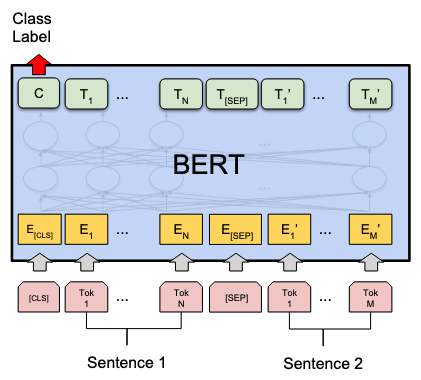

In [ ]:
example = rte_dataset["train"][0]
tokenized_example = tokenizer(
    example["sentence1"],
    example["sentence2"], 
    max_length=64,
    padding="max_length",
    truncation=True,
)
print(tokenized_example.keys())
print(tokenized_example["input_ids"])
print(tokenized_example["attention_mask"])
print()
print(tokenizer.decode(tokenized_example["input_ids"]))

Now, we can use the `.map` method in `datasets` to apply our tokenization over the whole dataset at once.

In [ ]:
def tokenize_rte_example(example):
  tokenized_example = tokenizer(
      example["sentence1"],
      example["sentence2"], 
      max_length=64,
      padding="max_length",
      truncation=True,
  )
  # Skip dummy label for test set
  if example["label"] != -1:
    tokenized_example["label"] = example["label"]
  return tokenized_example

tokenized_rte_dataset = rte_dataset.map(
    tokenize_rte_example,
    remove_columns=["sentence1", "sentence2", "idx"]
)

In [ ]:
print(tokenized_rte_dataset["train"][0])

From the tokenized dataset, we can built our usual data loaders.

`transformers` also comes with a pre-written `collate_fn` that works natively with dataset objects.

In [ ]:
BATCH_SIZE = 32
train_dataloader = DataLoader(
    tokenized_rte_dataset["train"],
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=transformers.data.DataCollatorWithPadding(tokenizer),
)
val_dataloader = DataLoader(
    tokenized_rte_dataset["validation"],
    batch_size=BATCH_SIZE * 2,
    shuffle=False,
    collate_fn=transformers.data.DataCollatorWithPadding(tokenizer),
)

#### Model

Now, let's start building our model.

First, let's load the RoBERTa encoder. This gets us all the layers of the encoder except the MLM head, which we will not be using.

In [ ]:
encoder = transformers.RobertaModel.from_pretrained("roberta-base")
encoder = encoder.to(DEVICE)

In [ ]:
# Get the first batch for val dataloader
batch = to_device(next(iter(val_dataloader)))
for k, v in batch.items():
  print(k, tuple(v.shape))

Let's take a look at what the encoder outputs.

In [ ]:
with torch.inference_mode():
  out = encoder(
      input_ids=batch["input_ids"],
      attention_mask=batch["attention_mask"],
  )

for k, v in out.items():
  print(k, tuple(v.shape))

We see that we get two outputs:

- `last_hidden_state`: (bs, len, hidden), which provides the final hidden states for each token.
- `pooler_output`: (bs, hidden), which is the representation for just the `[CLS]` or `<s>` token, additionally fed through another MLP layer

In our case we will just want to take the `pooler_output` and feed it to a linear layer to get our logits over two classes.

A common practice is to put the loss function within the forward method of the model itself. (One reason for this is that it works slightly better with multi-GPU setups.)

In [ ]:
class SequenceClassificationModel(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.encoder = transformers.RobertaModel.from_pretrained("roberta-base")
    self.linear = nn.Linear(self.encoder.config.hidden_size, num_classes)

  def forward(self, batch):
    encoder_out = self.encoder(
        input_ids=batch["input_ids"],
        attention_mask=batch["attention_mask"],
    )
    logits = self.linear(encoder_out["pooler_output"])
    result = {"logits": logits}
    if "labels" in batch:
      result["loss"] = F.cross_entropy(logits, batch["labels"])
    return result

In [ ]:
model = SequenceClassificationModel(num_classes=2).to(DEVICE)

In [ ]:
with torch.inference_mode():
  out = model(batch)
  
for k, v in out.items():
  print(k, tuple(v.shape))

#### Fine-tuning

Now that we have all the pieces we need, we can start training.

Please note what we are doing here: we are going to fine-tune **all parameters in the model**. This used to be uncommon, but was found to work particularly well with these large pretrained Transformer models.

Because we are going to fine-tune a large model with relatively little data, we will use a an annuealing scheduler with warm-up. This essentially modifies the learning rate over time, with the following pattern.

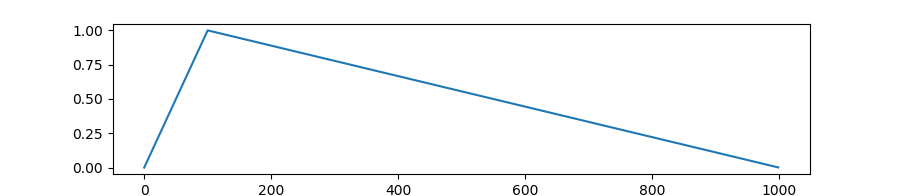

In [ ]:
num_epochs = 5

model = SequenceClassificationModel(num_classes=2).to(DEVICE)
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
scheduler = transformers.get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=100,
    num_training_steps=len(train_dataloader) * num_epochs,
)

In [ ]:
for epoch in range(num_epochs):
    train_loss_ls = []
    model.train()
    for batch in tqdm.tqdm(train_dataloader, desc="train"):
        optimizer.zero_grad()
        out = model(to_device(batch))
        out["loss"].backward()

        # Note: we need to .step both the optimizer and scheduler
        optimizer.step()
        scheduler.step()
        train_loss_ls.append(out["loss"].item())
        
    optimizer.zero_grad()
    train_loss = np.mean(train_loss_ls)

    # validation
    model.eval()
    is_correct = []
    val_loss_ls = []
    for batch in tqdm.tqdm(val_dataloader, desc="val"):
        batch = to_device(batch)
        with torch.inference_mode():
            out = model(batch)
        preds = out["logits"].argmax(-1).detach()
        is_correct.append((preds == batch["labels"]).cpu().float().numpy())
        val_loss_ls.append(out["loss"].item())
    acc = np.concatenate(is_correct).mean()
    val_loss = np.mean(val_loss_ls)
    print(f"Epoch {epoch}: Accuracy = {acc}, Train Loss = {train_loss}, Val Loss = {val_loss}")

### BERT for Question-Answering

#### Data

Now let's consider a different task: SQuAD. SQuAD is the Stanfard Question-Answering dataset. The task looks like this:

> **Context**: Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to <u>**Saint Bernadette Soubirous**</u> in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.

> **Question**: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?

> **Answers**: Saint Bernadette Soubirous

Given a context and question, the answer is a span (usually an entity) from the context. So essentially, this becomes "span-prediction" task.

In [ ]:
import numpy as np
import datasets
import torch
import torch.nn as nn
from transformers import AdamW
import transformers
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
import tqdm.notebook as tqdm
import itertools

MAX_LENGTH = 384
DEVICE = torch.device("cuda:0")
def to_device(batch):
  return {
      k: v.to(DEVICE)
      for k, v in batch.items()
  }

In [ ]:
# Use fewer validation examples for speed
squad_dataset = {
    "train": datasets.load_dataset("squad", split="train"),
    "validation": datasets.load_dataset("squad", split="validation[:1000]"),
}
squad_dataset

In [ ]:
example = squad_dataset["train"][0]
example

#### Preprocessing

There are some additional complications that we have to deal with:

- We need to map the labels (in characters) to spans (in tokens). This can be very non-trivial.
- The contexts can be relatively long, maybe even longer than the model's max sequence length
- The answer may appear several times in the context.

There can be several more sophisticated tricks to get the best performance out of this dataset. We will apply some of them here.

Importantly, we need to deal with mapping spans to characters. The `transformers` tokenizer comes with the functionality to map each tokenized token to the input character spans.

In [ ]:
tokenizer = transformers.RobertaTokenizerFast.from_pretrained("roberta-base")

In [ ]:
sent1 = "My name is Robert Baratheon."
sent2 = "I am Lord of the Seven Kingdoms."
tokenized_example = tokenizer(
    sent1,
    sent2,
    max_length=MAX_LENGTH,
    truncation="only_second",
    return_offsets_mapping=True,
)

In [ ]:
# Each token has a corresponding 2-ple of start/end character indices
tokenized_example["offset_mapping"]

In [ ]:
# Sequence ID tells us which input (1 or 2) the token/string comes from
tokenized_example.sequence_ids()

In [ ]:
sent_list = [sent1, sent2]
print("seq_id   offsets      token     string")
print("--------------------------------------")
for i, (seq_id, offsets) in enumerate(zip(
    tokenized_example.sequence_ids(),
    tokenized_example["offset_mapping"])):
  start, end = offsets
  print(
      str(seq_id).rjust(6), 
      str(offsets).rjust(9),
      tokenizer.convert_ids_to_tokens(tokenized_example["input_ids"][i]).rjust(10),
      (sent_list[seq_id][start:end] if seq_id is not None else "-").rjust(10),
  )

In [ ]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=MAX_LENGTH,
    truncation="only_second",
    return_offsets_mapping=True,
)

Here, the preprocessing gets a bit hairy, so try to follow the big idea but don't get bogged down by the details.

The main idea is that we want to be able to recover the tokens corresponding to the answer.

First, let's ensure we can grab the answer from the text **string**.

In [ ]:
# The logic here looks complicated, but it's really just simple index lookups.
sequence_ids = tokenized_example.sequence_ids()
context_token_indices = [i for i, seq_id in enumerate(sequence_ids) if seq_id == 1]
context_start_token_idx = min(context_token_indices)
context_end_token_idx = max(context_token_indices) + 1 # exclusive

print(context_start_token_idx, context_end_token_idx)
print(sequence_ids[context_start_token_idx: context_end_token_idx])

answer_start_char = example["answers"]["answer_start"][0]
answer_end_char = answer_start_char + len(example["answers"]["text"][0])

print(answer_start_char, answer_end_char)
# Check that it's correct
print(example["answers"]["text"][0])
print(example["context"][answer_start_char: answer_end_char])

First, next, we find which **tokens** the answer is located in, which should match the above.

In [ ]:
# The logic here looks complicated, but it's really just simple index lookups.
offsets = tokenized_example["offset_mapping"]
answer_start_token_idx = context_start_token_idx
while answer_start_token_idx < len(offsets) and offsets[answer_start_token_idx][0] <= answer_start_char:
    answer_start_token_idx += 1
answer_start_token_idx -= 1
answer_end_token_idx = context_end_token_idx - 1
while offsets[answer_end_token_idx][1] >= answer_end_char:
    answer_end_token_idx -= 1
answer_end_token_idx += 1

# Check that it's correct
answer_token_ids = tokenized_example["input_ids"][answer_start_token_idx: answer_end_token_idx + 1]
print(answer_token_ids)
tokenizer.decode(answer_token_ids)

With all that, we know what the start/end indices we need our model to predict, so we can start tokenization.

One last thing: because our tokenization setup creates potentially multiple "examples" per example, we need to keep track of the actual true example IDs. In SQuAD, each example is labeled with a unique string id. We will create two dictionaries mapping from string to numerical IDs.

In [ ]:
str_ids_to_num_ids = {}
for str_id in squad_dataset["train"]["id"] + squad_dataset["validation"]["id"]:
  str_ids_to_num_ids[str_id] = len(str_ids_to_num_ids)
num_ids_to_str_ids = {v: k for k, v in str_ids_to_num_ids.items()}

Also, because we are creating one-to-multiple examples, we will use the `batched=True` mode of the dataset `.map` method.

In [ ]:
def tokenize_example(example):
  tokenized_example = tokenizer(
      example["question"].lstrip(),
      example["context"],
      max_length=MAX_LENGTH,
      truncation="only_second",
      return_offsets_mapping=True,
  )
  sequence_ids = tokenized_example.sequence_ids()
  context_token_indices = [i for i, seq_id in enumerate(sequence_ids) if seq_id == 1]
  context_start_token_idx = min(context_token_indices)
  context_end_token_idx = max(context_token_indices) + 1 # exclusive

  answer_start_char = example["answers"]["answer_start"][0]
  answer_end_char = answer_start_char + len(example["answers"]["text"][0])

  offsets = tokenized_example["offset_mapping"]
  answer_start_token_idx = context_start_token_idx
  while answer_start_token_idx < len(offsets) and offsets[answer_start_token_idx][0] <= answer_start_char:
      answer_start_token_idx += 1
  answer_start_token_idx -= 1
  answer_end_token_idx = context_end_token_idx - 1
  while offsets[answer_end_token_idx][1] >= answer_end_char:
      answer_end_token_idx -= 1
  answer_end_token_idx += 1
  if answer_start_token_idx >= answer_end_token_idx:
    pass

  features = {
      "answer_start_token_idx": answer_start_token_idx,
      "answer_end_token_idx": answer_end_token_idx,
      "input_ids": tokenized_example["input_ids"],
      "attention_mask": tokenized_example["attention_mask"],
      "id": str_ids_to_num_ids[example["id"]],
  }
  return features

In [ ]:
tokenized_squad_train_dataset = squad_dataset["train"].map(
    tokenize_example,
    remove_columns=squad_dataset["train"].column_names
)
tokenized_squad_val_dataset = squad_dataset["validation"].map(
    tokenize_example,
    remove_columns=squad_dataset["validation"].column_names
)

In [ ]:
BATCH_SIZE = 16
squad_train_dataloader = DataLoader(
    tokenized_squad_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=transformers.data.DataCollatorWithPadding(tokenizer),
)
squad_val_dataloader = DataLoader(
    tokenized_squad_val_dataset,
    batch_size=BATCH_SIZE * 2,
    shuffle=False,
    collate_fn=transformers.data.DataCollatorWithPadding(tokenizer),
)

#### Model

Now, let's build our model. Most of the complexity was in the preprocessing, now we just need to predict the start and end indices.

Key idea: Instead of doing a softmax over classes, we can do a softmax over the sequence!

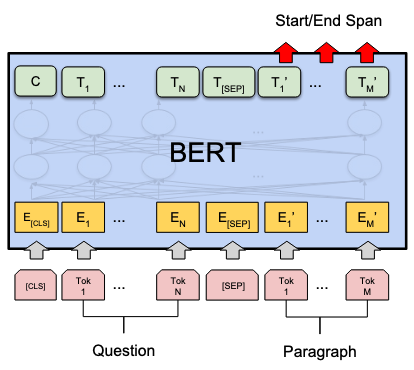

In [ ]:
encoder = transformers.RobertaModel.from_pretrained("roberta-base")
encoder = encoder.to(DEVICE)

batch = to_device(next(iter(squad_val_dataloader)))

with torch.inference_mode():
    encoder_out = encoder(
        input_ids=batch["input_ids"],
        attention_mask=batch["attention_mask"],
    )

Like before, we are creating a linear layer to 2 dimensions, but remember that the outputs will be used quite differently. The 2 dimensions correspond to start/end token predictions.

In [ ]:
linear = nn.Linear(encoder.config.hidden_size, 2).to(DEVICE)

In [ ]:
# Compute the logits
with torch.inference_mode():
    logits = linear(encoder_out.last_hidden_state)
print(logits.shape)

In [ ]:
# Split into start and end logits
start_logits, end_logits = logits.split(1, dim=-1)
print(start_logits.shape)

In [ ]:
# Mask out the padding tokens by multiplying logits with a large negative number
start_logits = start_logits.squeeze(-1) + (1-batch["attention_mask"]) * -1e10
end_logits = end_logits.squeeze(-1) + (1-batch["attention_mask"]) * -1e10

In [ ]:
# Compute the cross entropy over the sequence length
# We have separate start and end losses
start_loss = F.cross_entropy(start_logits, batch["answer_start_token_idx"])
end_loss = F.cross_entropy(end_logits, batch["answer_end_token_idx"])
total_loss = (start_loss + end_loss) / 2

So the model is relatively straightfoward to set up.

In [ ]:
class SpanPredictionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = transformers.RobertaModel.from_pretrained("roberta-base")
    self.linear = nn.Linear(self.encoder.config.hidden_size, 2)

  def forward(self, batch):
    encoder_out = self.encoder(
        input_ids=batch["input_ids"],
        attention_mask=batch["attention_mask"],
    )
    logits = self.linear(encoder_out["last_hidden_state"])
    start_logits, end_logits = logits.split(1, dim=-1)
    start_logits = start_logits.squeeze(-1) + (1-batch["attention_mask"]) * -1e10
    end_logits = end_logits.squeeze(-1) + (1-batch["attention_mask"]) * -1e10

    start_loss = F.cross_entropy(start_logits, batch["answer_start_token_idx"])
    end_loss = F.cross_entropy(end_logits, batch["answer_end_token_idx"])
    total_loss = (start_loss + end_loss) / 2
    return {
        "start_logits": start_logits,
        "end_logits": end_logits,
        "loss": total_loss,
    }

#### Fine-tuning

Now, let's start training. For this lab, we'll just train over a small number of steps.

In [ ]:
num_steps = 500
val_interval = 100

model = SpanPredictionModel().to(DEVICE)
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
scheduler = transformers.get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=100,
    num_training_steps=num_steps,
)

In [ ]:
train_iter = iter(squad_train_dataloader)
for interval in range(num_steps // val_interval):
    train_loss_ls = []
    model.train()
    for _ in tqdm.trange(val_interval):
        batch = next(train_iter)
        optimizer.zero_grad()
        out = model(to_device(batch))
        out["loss"].backward()
        optimizer.step()
        scheduler.step()
        train_loss_ls.append(out["loss"].item())
    optimizer.zero_grad()
    train_loss = np.mean(train_loss_ls)

    # validation
    model.eval()
    val_loss_ls = []
    # Just eval 30 examples for speed
    for batch in tqdm.tqdm(squad_val_dataloader, desc="val", total=30):
        batch = to_device(batch)
        with torch.inference_mode():
            out = model(batch)
        val_loss_ls.append(out["loss"].item())
        if len(val_loss_ls) > 30:
          break
    val_loss = np.mean(val_loss_ls)
    print(f"Interval {interval}: Train Loss = {train_loss}, Val Loss = {val_loss}")

#### Evaluation

Now we have a model for predicting spans, but we haven't actually talked about how SQuAD is evaluated. The actual evaluation of SQuAD is relatively complex, involving some post processing (normalization of text), and scoring the F1 and exact match of tokens predicted from the answer spans.

Thankfully, `datasets` also comes with a set of `metrics`, that we can use to score our model.

In [ ]:
metric = datasets.load_metric("squad")

In [ ]:
references = [{"id": "UNIQUE_ID_1", "answers": {'answer_start': [123], 'text': ["The Answer."]}}]
predictions = [{"id": "UNIQUE_ID_1", "prediction_text": "semi-correct answer"}]

metric.compute(predictions=predictions, references=references)

Now, we run our model over the validation set.

We still need to do some post-processing ourselves, such as mapping from the spans to actual prediction text string. Secondly, we also need to pick out the higest scoring prediction for each example.

In [ ]:
model.eval()
predictions = []
for batch in tqdm.tqdm(squad_val_dataloader, desc="val"):
    batch = to_device(batch)
    with torch.inference_mode():
        out = model(batch)
    
    input_ids = batch["input_ids"].cpu().numpy()
    start_pred = out["start_logits"].argmax(-1)
    end_pred = out["end_logits"].argmax(-1)

    for i in range(input_ids.shape[0]):
        # Get the predicted string for each
        pred_str = tokenizer.decode(input_ids[i, start_pred[i]: end_pred[i]+1].tolist()).strip()
        str_id = num_ids_to_str_ids[batch["id"][i].item()]

        predictions.append({
            "prediction_text": pred_str,
            "id": str_id,
        })

In [ ]:
references = [
    {"id": example["id"], "answers": example["answers"]}
    for example in squad_dataset["validation"]
]

In [ ]:
metric.compute(predictions=predictions, references=references)

### Hugging Face Ecosystem

The `transformers` library actually provides easy access to many different transformer models.

In [ ]:
# These are just the transformers, without output heads
bert = transformers.BertModel.from_pretrained("bert-base-cased")
gpt2 = transformers.GPT2Model.from_pretrained("gpt2")
electra = transformers.ElectraModel.from_pretrained("google/electra-base-discriminator")

Furthermore, `transformers` often has the task-specific model implementations that we wrote above already implemented.

In [ ]:
# QA / Span-Classification (needs fine-tuning!)
bert_qa = transformers.BertForQuestionAnswering.from_pretrained("bert-base-cased")

# LM (from pretrained)
gpt2_lm = transformers.GPT2LMHeadModel.from_pretrained("gpt2")

# Sequence Classification (needs fine-tuning!)
electra_sentiment = transformers.ElectraForSequenceClassification.from_pretrained("google/electra-base-discriminator", num_labels=2)

Note that for `bert_qa` and `electra_sentiment`, the QA and classification heads are both randomly initialized respectively, and still need to be fine-tuned.

In contrast, `gpt2_lm` uses the LM prediction head from its pretraining, and so it can be used out of the box.

#### Model Hub

We mentioned above that we can easily load **pretrained** model weights. In the same vein, we can also easily load **fine-tuned models.**

For example, suppose we're looking for some already fine-tuned RoBERTa-base SQuAD models. We can search here:

https://huggingface.co/models?sort=downloads&search=roberta+squadv1 

In [ ]:
# Fully fine-tuned!
model = transformers.RobertaForQuestionAnswering.from_pretrained(
    "csarron/roberta-base-squad-v1"
).to(DEVICE)

In [ ]:
# Same code as above, except model() has a slightly different input

model.eval()
predictions = []
for batch in tqdm.tqdm(squad_val_dataloader, desc="val"):
    batch = to_device(batch)
    with torch.inference_mode():
        # Slightly different input signature
        out = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            start_positions=batch["answer_start_token_idx"],
            end_positions=batch["answer_end_token_idx"],
        )
    
    # Get the start- and end-token predictions
    start_pred = out["start_logits"].argmax(-1)
    end_pred = out["end_logits"].argmax(-1)
    input_ids = batch["input_ids"].cpu().numpy()

    for i in range(input_ids.shape[0]):
        # Get the predicted string for each
        pred_str = tokenizer.decode(input_ids[i, start_pred[i]: end_pred[i]+1].tolist()).strip()
        str_id = num_ids_to_str_ids[batch["id"][i].item()]
        predictions.append({
            "prediction_text": pred_str,
            "id": str_id,
        })

In [ ]:
metric.compute(predictions=predictions, references=references)

## More materials

We covered a lot of practical material in this lab.

* Additional `transformers` example notebooks:
  - [Question-answering](https://colab.research.google.com/github/huggingface/notebooks/blob/master/examples/question_answering.ipynb#scrollTo=H0VISQmwDa1h)
  - [Text classification](https://colab.research.google.com/github/huggingface/notebooks/blob/master/examples/text_classification.ipynb#scrollTo=MOsHUjgdIrIW)
* [Trainer](https://huggingface.co/transformers/main_classes/trainer.html), which handles a lot of the training, checkpointing and evaluation loop